<a href="https://colab.research.google.com/github/The-cheater/Deep_Learning_Models/blob/main/cifar10_MM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Input, Model

# Load CIFAR-10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32')  / 255.0

# Convert RGB to grayscale
x_train_gray = np.dot(x_train[..., :3], [0.2989, 0.5870, 0.1140])[..., np.newaxis]
x_test_gray  = np.dot(x_test[..., :3], [0.2989, 0.5870, 0.1140])[..., np.newaxis]

# Data pipeline (no resizing, minimal augmentation to prevent system crashes)
batch_size = 64
train_ds = tf.data.Dataset.from_tensor_slices(((x_train, x_train_gray), y_train))
train_ds = train_ds.shuffle(50000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices(((x_test, x_test_gray), y_test))
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# CNN model
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    return x

input_rgb = Input(shape=(32, 32, 3), name='rgb_input')
input_gray = Input(shape=(32, 32, 1), name='gray_input')

# RGB stream
x1 = layers.Conv2D(32, 3, padding='same', activation='relu')(input_rgb)
x1 = conv_block(x1, 64)
x1 = conv_block(x1, 128)
x1 = conv_block(x1, 128)

# Grayscale stream
x2 = layers.Conv2D(32, 3, padding='same', activation='relu')(input_gray)
x2 = conv_block(x2, 64)
x2 = conv_block(x2, 128)
x2 = conv_block(x2, 128)

# Concatenation and further layers
x = layers.Concatenate(axis=-1)([x1, x2])
x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
output = layers.Dense(10, activation='softmax')(x)

model = Model(inputs=[input_rgb, input_gray], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Training
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    callbacks=callbacks
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ rgb_input           │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gray_input          │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        896 │ rgb_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │        320 │ gray_input[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     18,496 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 128) │    147,584 │ max_pooling2d_1[

 Total params: 1,734,218 (6.62 MB)

 Trainable params: 1,731,914 (6.61 MB)

 Non-trainable params: 2,304 (9.00 KB)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.4934 - loss: 1.4278 - val_accuracy: 0.6740 - val_loss: 0.9053
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.7503 - loss: 0.7110 - val_accuracy: 0.7153 - val_loss: 0.8191
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.8310 - loss: 0.4933 - val_accuracy: 0.7740 - val_loss: 0.6619
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.8752 - loss: 0.3611 - val_accuracy: 0.7414 - val_loss: 0.7920
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9133 - loss: 0.2551 - val_accuracy: 0.7854 - val_loss: 0.7223
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9364 - loss: 0.1798 - val_accuracy: 0.7782 - val_loss: 0.8186
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9538 - loss: 0.1305 - val_accuracy: 0.7543 - val_loss: 0.9695
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9634 - loss: 0.1043 - 

In [2]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7747 - loss: 0.6569
Test accuracy: 0.7740
Test loss: 0.6619


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


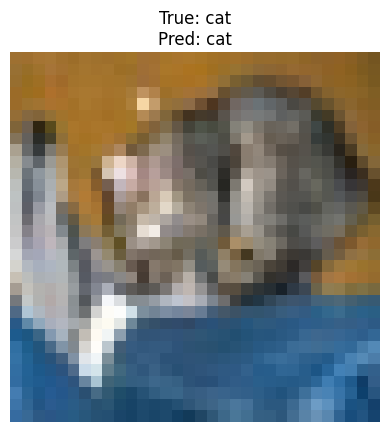

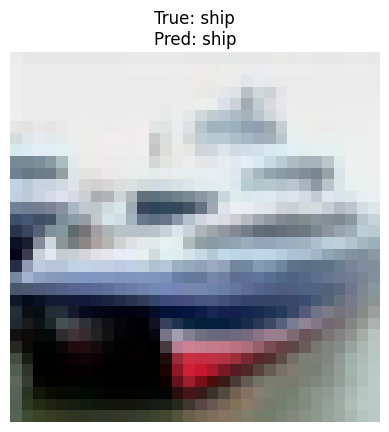

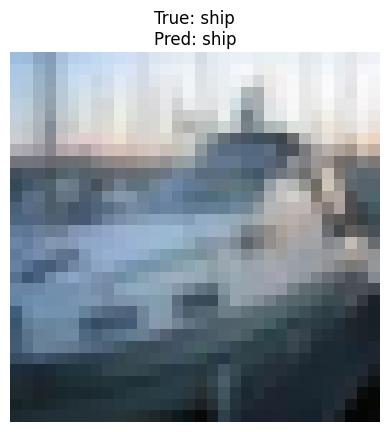

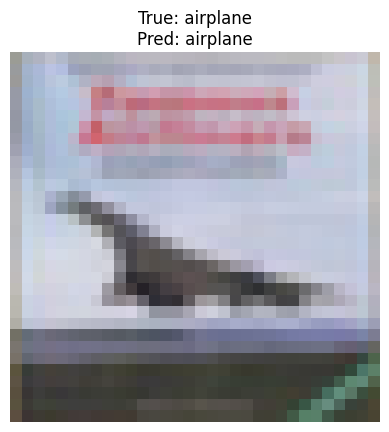

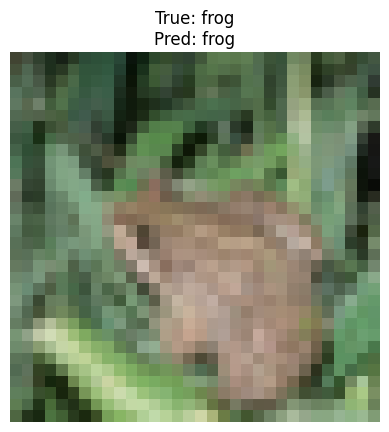

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Get a small batch from the test set
for (x_rgb, x_gray), y_true in test_ds.take(1):
    y_pred = model.predict((x_rgb, x_gray))
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Plot the first 5 images
    for i in range(5):
        plt.imshow(x_rgb[i].numpy())
        plt.title(f"True: {class_names[y_true[i][0]]}\nPred: {class_names[y_pred_labels[i]]}")
        plt.axis('off')
        plt.show()


In [4]:
idx = 0  # Pick an index from test set
sample_rgb = x_test[idx:idx+1]  # Shape (1, 32, 32, 3)
sample_gray = x_test_gray[idx:idx+1]  # Shape (1, 32, 32, 1)

prediction = model.predict((sample_rgb, sample_gray))
predicted_class = class_names[np.argmax(prediction)]

print(f"Predicted class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted class: cat
